### Importing required libraries

In [4]:
import pandas as pd 
import numpy as np               
import seaborn as sns                
import matplotlib.pyplot as plt   
plt.figure(dpi=600)
%matplotlib inline

# import warnings filter
# from warnings import simplefilter

from warnings import filterwarnings
filterwarnings('ignore')

# ignore all future warnings
# simplefilter(action='ignore', category=FutureWarning)
# simplefilter(action='ignore', category=ConvergenceWarning)

from sklearn.metrics import accuracy_score

In [52]:
train = pd.read_csv('final_train.csv')

test = pd.read_csv('final_test.csv')

submission = pd.read_csv('sample_submission.csv')

In [53]:
train.shape, test.shape

((614, 13), (367, 12))

In [54]:
train.head()

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income,LoanAmount_log,Total_Income_log
0,Male,No,0,Graduate,No,128.0,360.0,1.0,Urban,1,5849.0,4.852030,8.674026
1,Male,Yes,1,Graduate,No,128.0,360.0,1.0,Rural,0,6091.0,4.852030,8.714568
2,Male,Yes,0,Graduate,Yes,66.0,360.0,1.0,Urban,1,3000.0,4.189655,8.006368
3,Male,Yes,0,Not Graduate,No,120.0,360.0,1.0,Urban,1,4941.0,4.787492,8.505323
4,Male,No,0,Graduate,No,141.0,360.0,1.0,Urban,1,6000.0,4.948760,8.699515


In [55]:
test.head()

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,LoanAmount_log,Total_Income,Total_Income_log
0,Male,Yes,0,Graduate,No,110.0,360.0,1.0,Urban,4.700480,5720,8.651724
1,Male,Yes,1,Graduate,No,126.0,360.0,1.0,Urban,4.836282,4576,8.428581
2,Male,Yes,2,Graduate,No,208.0,360.0,1.0,Urban,5.337538,6800,8.824678
3,Male,Yes,2,Graduate,No,100.0,360.0,1.0,Urban,4.605170,4886,8.494129
4,Male,No,0,Not Graduate,No,78.0,360.0,1.0,Urban,4.356709,3276,8.094378


### New Features that might affect the Target Variable

In [56]:
train['EMI'] = train['LoanAmount']/train['Loan_Amount_Term'] 
test['EMI'] = test['LoanAmount']/test['Loan_Amount_Term']

train['Balance Income'] = np.log(train['Total_Income']-(train['EMI']*100))
test['Balance Income'] = np.log(test['Total_Income']-(test['EMI']*100))

- #### Removing Redundant columns

In [57]:
columns_to_drop = ['Total_Income', 'LoanAmount', 'Loan_Amount_Term', 'Dependents']

train.drop(columns_to_drop, inplace=True, axis=1)

test.drop(columns_to_drop, inplace=True, axis=1)

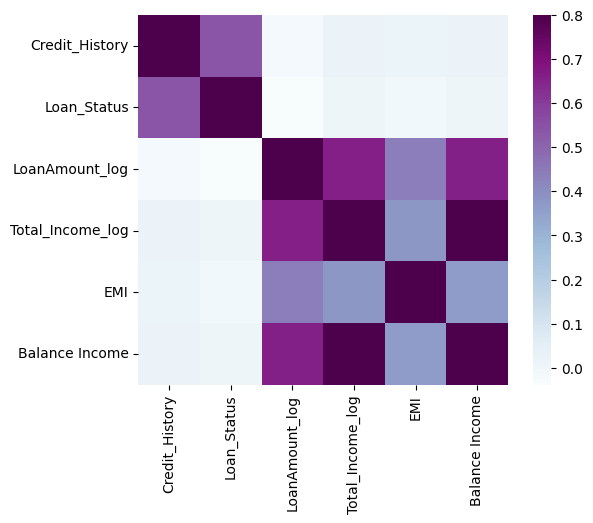

In [58]:
corr = train.corr() 
sns.heatmap(corr, vmax=.8, square=True, cmap="BuPu");

### One-Hot encoding of categorical variables

In [59]:
train = pd.get_dummies(train) 

test = pd.get_dummies(test)

train.columns

Index(['Credit_History', 'Loan_Status', 'LoanAmount_log', 'Total_Income_log',
       'EMI', 'Balance Income', 'Gender_Female', 'Gender_Male', 'Married_No',
       'Married_Yes', 'Education_Graduate', 'Education_Not Graduate',
       'Self_Employed_No', 'Self_Employed_Yes', 'Property_Area_Rural',
       'Property_Area_Semiurban', 'Property_Area_Urban'],
      dtype='object')

In [60]:
dummies_columns = ['Married_No', 'Gender_Female', 'Self_Employed_No', 'Education_Not Graduate']

train.drop(dummies_columns, inplace=True, axis=1)

test.drop(dummies_columns, inplace=True, axis=1)

### Splitting into features and labels

In [61]:
X = train.drop('Loan_Status',axis=1) 

y = train['Loan_Status']

In [62]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size =0.2)

### Submission

In [63]:
def Submission(filename, predictions):
    submission['Loan_Status'] = predictions 
    submission['Loan_Status'].replace({1:'Y', 0:'N'},inplace=True) 
    submission.to_csv(filename, index=False)

### Logistic Regression

In [64]:
from sklearn.linear_model import LogisticRegression 

logistic_regression = LogisticRegression() 

logistic_regression.fit(x_train, y_train)

LogisticRegression()

In [65]:
pred_logistic = logistic_regression.predict(x_test)

# Accuracy of Model
print('Accuracy Score : ', accuracy_score(y_test,pred_logistic))

# Predictions for unseen Labels
pred_test = logistic_regression.predict(test)

Submission('logistic_regression.csv', pred_test)

Accuracy Score :  0.8048780487804879


### Decision Tree

In [66]:
from sklearn import tree 

model = tree.DecisionTreeClassifier(random_state=42)

model.fit(x_train, y_train)     

DecisionTreeClassifier(random_state=42)

In [67]:
pred_dt = model.predict(x_test)     

print('Accuracy Score : ', accuracy_score(y_test, pred_dt))

# Predictions for unseen Labels
pred_test = model.predict(test)

Submission('decision_tree.csv', pred_test)

Accuracy Score :  0.7398373983739838


### Random Forest

In [68]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(random_state=1, max_depth=10)     

random_forest.fit(x_train, y_train)     

RandomForestClassifier(max_depth=10, random_state=1)

In [69]:
pred_rf = random_forest.predict(x_test)    

print('Accuracy Score : ', accuracy_score(y_test, pred_rf))

# Predictions for unseen Labels
pred_test = random_forest.predict(test)

Submission('random_forest.csv', pred_test)

Accuracy Score :  0.7886178861788617


<AxesSubplot: >

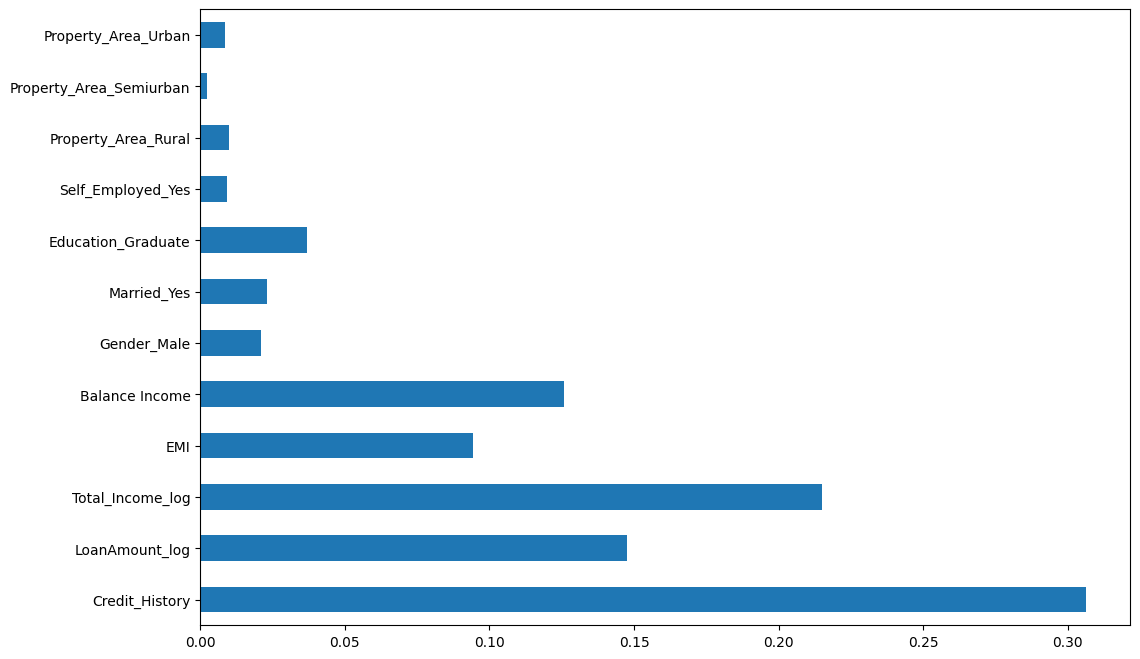

In [70]:
importances = pd.Series(model.feature_importances_, index = X.columns) 
importances.plot(kind = 'barh', figsize = (12,8))

### XGB Classifier

In [71]:
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier(n_estimators=50, max_depth=4)     

xgb_classifier.fit(x_train, y_train)     

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [72]:
pred_xgb = xgb_classifier.predict(x_test)     

print('accuracy_score', accuracy_score(y_test,pred_xgb))

# Predictions for unseen Labels
pred_test = xgb_classifier.predict(test)

Submission('xgb.csv', pred_test)

accuracy_score 0.7967479674796748


### SVM

In [73]:
from sklearn import svm

svm = svm.SVC(gamma='scale', C=1)

svm.fit(x_train, y_train)  

SVC(C=1)

In [74]:
pred_svm = svm.predict(x_test)     

print('Accuracy Score : ', accuracy_score(y_test, pred_svm))

# Predictions for unseen Labels
pred_test = svm.predict(test)

Submission('svm.csv', pred_test)

Accuracy Score :  0.8048780487804879


## KNN

In [85]:

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10,metric="minkowski",p=2)
knn.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=10)

In [86]:
pred_knn = knn.predict(x_test)     

print('Accuracy Score : ', accuracy_score(y_test, pred_knn))

pred_test = knn.predict(test)

Submission('knn.csv', pred_test)

Accuracy Score :  0.7723577235772358


## AdaBoostClassifier

In [88]:
from sklearn.ensemble import AdaBoostClassifier
adaboost = AdaBoostClassifier(n_estimators=20, learning_rate =1)
adaboost.fit(x_train,y_train)

AdaBoostClassifier(learning_rate=1, n_estimators=20)

In [89]:
pred_adaboost = adaboost.predict(x_test)     

print('Accuracy Score : ', accuracy_score(y_test, pred_adaboost))

pred_test = adaboost.predict(test)

Submission('adaboost.csv', pred_test)

Accuracy Score :  0.8130081300813008


In [90]:
from sklearn.naive_bayes import GaussianNB

# Build a Gaussian Classifier
model = GaussianNB()
model.fit(x_train,y_train)

GaussianNB()

In [91]:
pred_gau = model.predict(x_test)     

print('Accuracy Score : ', accuracy_score(y_test, pred_gau))

pred_test = model.predict(test)

Submission('naivebayes.csv', pred_test)

Accuracy Score :  0.7967479674796748


### Hyperparameter Tuning for Random Forest and XGB Model

In [75]:
from sklearn.model_selection import GridSearchCV

- ### Logistic Regression HT

In [76]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# max_iter = np.arange(200,1000,100)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
clf_lr = GridSearchCV(logistic_regression, hyperparameters, cv=5, verbose=0)

# Fit grid search
best_model_lr = clf_lr.fit(X, y)

# View best hyperparameters
print('Best Penalty:', best_model_lr.best_estimator_.get_params()['penalty'])
print('Best C:', best_model_lr.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 3593.813663804626


In [77]:
new_LR = LogisticRegression(solver='lbfgs', penalty='l2', C=3596.81366)
new_LR.fit(x_train, y_train)

new_pred_logistic = new_LR.predict(x_test)

# Accuracy of Model
print('Accuracy Score : ', accuracy_score(y_test,new_pred_logistic))

Accuracy Score :  0.8048780487804879
